Predicting Customer Propensity to Buy
In this example we'll use clicks on a website (the data from clicks) when someone is browsing to predict their propensity to buy the product.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
prospect_data = pd.read_csv('browsing.csv')
prospect_data.head(3)

,SESSION_ID,IMAGES,REVIEWS,FAQ,SPECS,SHIPPING,BOUGHT_TOGETHER,COMPARE_SIMILAR,VIEW_SIMILAR,WARRANTY,SPONSORED_LINKS,BUY
0,1001,0,0,1,0,1,0,0,0,1,0,0
1,1002,0,1,1,0,0,0,0,0,0,1,0
2,1003,1,0,1,1,1,0,0,0,1,0,0


In [4]:
prospect_data.dtypes

SESSION_ID         int64
IMAGES             int64
REVIEWS            int64
FAQ                int64
SPECS              int64
SHIPPING           int64
BOUGHT_TOGETHER    int64
COMPARE_SIMILAR    int64
VIEW_SIMILAR       int64
WARRANTY           int64
SPONSORED_LINKS    int64
BUY                int64
dtype: object

In [5]:
prospect_data.describe()

,SESSION_ID,IMAGES,REVIEWS,FAQ,SPECS,SHIPPING,BOUGHT_TOGETHER,COMPARE_SIMILAR,VIEW_SIMILAR,WARRANTY,SPONSORED_LINKS,BUY
count,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000
mean,1250.50000,0.51000,0.52000,0.44000,0.48000,0.52800,0.50000,0.58000,0.46800,0.53200,0.55000,0.37000
std,144.48183,0.50040,0.50010,0.49688,0.50010,0.49972,0.50050,0.49405,0.49947,0.49947,0.49799,0.48329
min,1001.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1125.75000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,1250.50000,1.00000,1.00000,0.00000,0.00000,1.00000,0.50000,1.00000,0.00000,1.00000,1.00000,0.00000
75%,1375.25000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
max,1500.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [6]:
prospect_data.corr().head()

,SESSION_ID,IMAGES,REVIEWS,FAQ,SPECS,SHIPPING,BOUGHT_TOGETHER,COMPARE_SIMILAR,VIEW_SIMILAR,WARRANTY,SPONSORED_LINKS,BUY
SESSION_ID,1.00000,-0.04489,0.08343,-0.05223,0.04438,0.03123,0.00427,0.02973,0.00125,0.04651,0.03954,0.02668
IMAGES,-0.04489,1.00000,-0.10090,-0.05803,0.10090,-0.12534,-0.02000,0.09808,0.04538,0.08291,0.11862,0.04682
REVIEWS,0.08343,-0.10090,1.00000,-0.03548,0.12179,0.01379,-0.00000,-0.04704,-0.01348,-0.06675,0.05633,0.40463
FAQ,-0.05223,-0.05803,-0.03548,1.00000,-0.04516,-0.00936,-0.04029,-0.14368,-0.03198,-0.01647,-0.17008,-0.09514
SPECS,0.04438,0.10090,0.12179,-0.04516,1.00000,-0.10200,-0.12010,-0.15573,0.14184,0.05873,-0.13679,0.00995


In [7]:
#To determine which columns are related to 'ORDERED' (Ordered target column & highest correlation)
correlation = prospect_data.corr()['BUY']
correlation.nlargest(8)

BUY               1.00000
REVIEWS           0.40463
COMPARE_SIMILAR   0.19052
WARRANTY          0.17916
SPONSORED_LINKS   0.11033
IMAGES            0.04682
SESSION_ID        0.02668
SPECS             0.00995
Name: BUY, dtype: float64

<AxesSubplot:>

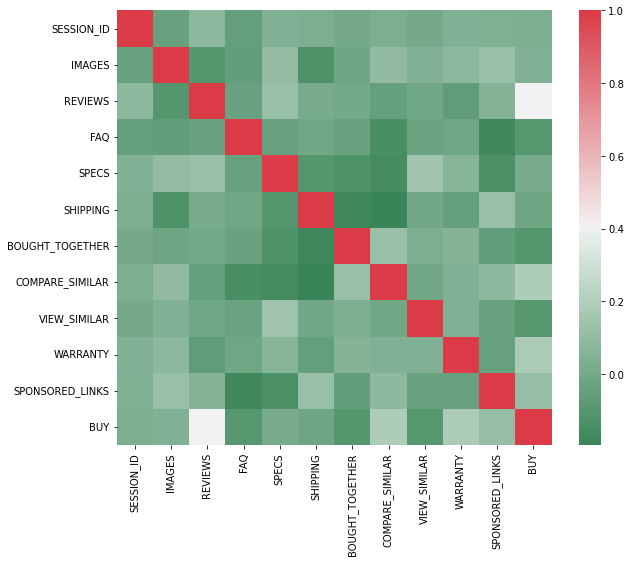

In [8]:
#to display correlations using a heatmap
f,ax = plt.subplots(figsize=(10,8))
corr = prospect_data.corr()
sn.heatmap(corr,mask=np.zeros_like(corr, dtype=bool), cmap=sn.diverging_palette(-220,10,as_cmap=True), square=True, ax=ax)

<AxesSubplot:xlabel='SPECS', ylabel='BUY'>

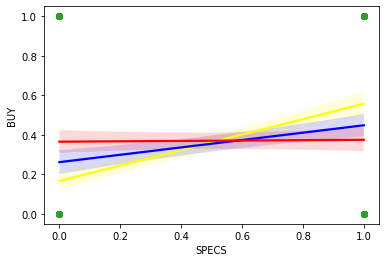

In [12]:
# use Seaborn regplot to show a scatterplot of highest correlated value. 
sn.regplot(x=prospect_data["REVIEWS"], y=prospect_data["BUY"], line_kws={"color": "yellow"})
sn.regplot(x=prospect_data["COMPARE_SIMILAR"], y=prospect_data["BUY"], line_kws={"color": "blue"})
sn.regplot(x=prospect_data["SPECS"], y=prospect_data["BUY"], line_kws={"color": "red"})

In [13]:
#Looking at correlations - 'Reviews','Compare_similar', 'Warranty','Sponsored Links' have medium correlation to BUY.
predictors = prospect_data[['REVIEWS','COMPARE_SIMILAR','WARRANTY','SPONSORED_LINKS']]
targets = prospect_data.BUY
predictors.head(3)

,REVIEWS,COMPARE_SIMILAR,WARRANTY,SPONSORED_LINKS
0,0,0,1,0
1,1,0,0,1
2,0,0,1,0


# Training & Testing Split

In [17]:
#Construct an algorithm that can learn and make preictions in a task. 
#To train and test the data - use ratio of 70:30 (70% of the data is used to train model; 30% to test model).
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, test_size=.3)
print('Predictor - Training: ',pred_train.shape, 'Predictor - Testing: ', pred_test.shape)

Predictor - Training:  (350, 4) Predictor - Testing:  (150, 4)


In [18]:
#Use a preexisting naive bayes classifier to create a matrix array.

from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier = classifier.fit(pred_train, tar_train)
predictions = classifier.predict(pred_test)

sklearn.metrics.confusion_matrix(tar_test, predictions)

array([[78, 11],
       [29, 32]], dtype=int64)

In [20]:
#To test the accuracy of the prediction (=73%)
sklearn.metrics.accuracy_score (tar_test, predictions).round(2)

0.73

In [21]:
#The probability that the prospect will BUY the product(=15% chance of BUYING).
#So this is the probability when clicks on any 1 column.
pred_prob = classifier.predict_proba(pred_test)
pred_prob[0,1].round(2)

0.15

In [22]:
#Real time predictions - customer does not visit ANY of the 4 pages 
#(only 4% prediction they will BUY). The array = [reviews,compare similiar,warranty, sponsored links]

no_clicks = np.array([0,0,0,0]).reshape(1,-1)
print('New visitor - propensity to buy: ', classifier.predict_proba(no_clicks)[:,1])

New visitor - propensity to buy:  [0.04277527]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [25]:
#Real time predictions - customer clicks ONLY on 'Reviews' of the 4 pages. 
#(only 25% prediction they will BUY). The array = [reviews,compare similiar,warranty, sponsored links]

reviews_clicked = np.array([1,0,0,0]).reshape(1,-1)
print('New visitor - propensity to buy: ', classifier.predict_proba(reviews_clicked)[:,1])

New visitor - propensity to buy:  [0.25071827]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [29]:
#Clicking both 'Reviews' & 'Compare Similar' (45% of BUYING)
review_similar = np.array([1,1,0,0]).reshape(1,-1)
print('New visitor - propensity to buy: ', classifier.predict_proba(review_similar)[:,1])

New visitor - propensity to buy:  [0.44602294]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [31]:
#Clicking both 'Reviews' & 'Compare Similar' & Warranty'  (67% of BUYING)
review_similar_warranty = np.array([1,1,1,0]).reshape(1,-1)
print('New visitor - propensity to buy: ', classifier.predict_proba(review_similar_warranty)[:,1])

New visitor - propensity to buy:  [0.67069406]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [32]:
#Clicking both 'Reviews' & 'Compare Similar' & Warranty' & 'LINKS' (?% of BUYING)
all_clicked = np.array([1,1,1,1]).reshape(1,-1)
print('New visitor - propensity to buy- All Clicked: ', classifier.predict_proba(all_clicked)[:,1])

New visitor - propensity to buy- All Clicked:  [0.76671793]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


# Prediction model is important because it allows the company to offer (or support) the customer based on how likely the customer is to buy - therefore prioritise 'best' customers.